<p align = "center" draggable=”false” ><img src="https://user-images.githubusercontent.com/37101144/161836199-fdb0219d-0361-4988-bf26-48b0fad160a3.png" 
     width="200px"
     height="auto"/>
</p>

# ⛽ Fuel efficiency Prediction

Provided with the classic [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) dataset, we will predict the **fuel efficiency** of the late-1970s and early 1980s automobiles, leveraging features such as cylinders, displacement, horsepower, weight, etc. 

It is a very small dataset and there are only a few features. We will first build a linear model and a neural network, evaluate their performances, track our experiment runs and inspect the logs using MLflow, and apply [TPOT](https://github.com/EpistasisLab/tpot) to see how it can be used to search over many ML model architectures, followed by explaining the model with SHAP.

# 📚 Learning Objectives

By the end of this session, you will be able to

- understand the core building blocks of a neural network
- understand what dense and activation layers do
- build, train, and evaluate neural networks
- track tensorflow experiments with MLflow, access information of runs programmatically and with its tracking ui
- perform AutoML to search for optimal tree-based pipeline for a regression task 

Note: [State of Data Science and Machine Learning 2021](https://www.kaggle.com/kaggle-survey-2021) by Kaggle shows that the most commonly used algorithms were linear and logtistic regressions, followed closely by decision trees, random forests, and gradient boosting machines (are you surprised?). Multilayer perceptron, or artificial neural networks are not yet the popular tools for tabular/structured data; see more technical reasons in papers: [Deep Neural Networks and Tabular Data: A Survey](https://arxiv.org/abs/2110.01889), [Tabular Data: Deep Learning is Not All You Need](https://arxiv.org/abs/2106.03253). For this assignment, the main purpose is for you to get familiar with the basic building blocks in constructing neural networks before we dive into more specialized neural network architectures.


**IMPORTANT**

You only need to run the following cells if you're completing the assignment in Google Collab. If you've already installed these libraries locally, you can skip installing these libraries.

In [1]:
# Connect colab to your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q seaborn # pairplot
!pip install -q tpot  # automl

!pip install -q mlflow # tracking
!pip install -q pyngrok # workaround to run mlflow ui in colab
!pip install -q shap

     |████████████████████████████████| 87 kB 2.7 MB/s 
     |████████████████████████████████| 139 kB 25.8 MB/s 
     |████████████████████████████████| 193.6 MB 63 kB/s 
     |████████████████████████████████| 16.5 MB 5.3 MB/s 
     |████████████████████████████████| 182 kB 63.0 MB/s 
     |████████████████████████████████| 209 kB 18.2 MB/s 
     |████████████████████████████████| 79 kB 5.6 MB/s 
     |████████████████████████████████| 82 kB 390 kB/s 
     |████████████████████████████████| 575 kB 67.0 MB/s 
     |████████████████████████████████| 147 kB 76.0 MB/s 
     |████████████████████████████████| 78 kB 1.8 MB/s 
     |████████████████████████████████| 62 kB 782 kB/s 
     |████████████████████████████████| 55 kB 2.6 MB/s 
     |████████████████████████████████| 140 kB 59.1 MB/s 
     |████████████████████████████████| 62 kB 1.3 MB/s 
     |████████████████████████████████| 761 kB 5.3 MB/s 


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [4]:
import tensorflow as tf
from tensorflow.keras import layers

print(tf.__version__)

2.9.2


# Task 1 - Data: Auto MPG dataset

0. Start MLflow's automatic logging using library-specific autolog calls for tensorflow: logging metrics, parameters, and models without the need for explicit log statements. 
    
    We will get into more details using **MLflow** after completing our experiment.

In [5]:
import mlflow
mlflow.tensorflow.autolog() # MLflow Autologging

1. The dataset is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/). First download and import the dataset using `pandas`:


In [6]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = [
  'MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
  'Acceleration', 'Model Year', 'Origin'
  ]

dataset = pd.read_csv(url, names=column_names, na_values='?', 
                      comment='\t', sep=' ', skipinitialspace=True)

In [7]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


2. The dataset contains a few unknown values, we drop those rows to keep this initial tutorial simple. Use `pd.DataFrame.dropna()`:

In [8]:
dataset.shape

(398, 8)

In [11]:
dataset[dataset.isna().any(axis=1)]

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
32,25.0,4,98.0,NaN,2046.0,19.0,71,1
126,21.0,6,200.0,NaN,2875.0,17.0,74,1
330,40.9,4,85.0,NaN,1835.0,17.3,80,2
336,23.6,4,140.0,NaN,2905.0,14.3,80,1
354,34.5,4,100.0,NaN,2320.0,15.8,81,2
374,23.0,4,151.0,NaN,3035.0,20.5,82,1


6 rows in the dataset have NaN values for `Horsepower`. 

In [12]:
dataset = dataset.dropna() # YOUR CODE HERE

In [16]:
dataset.shape

(392, 8)

Left with 392 rows of data after removing the 6 rows with NaN.

3. The `"Origin"` column is categorical, not numeric. So the next step is to one-hot encode the values in the column with [pd.get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html).

In [17]:
dataset['Origin'] = dataset['Origin'].replace({1: 'USA', 2: 'Europe', 3: 'Japan'})

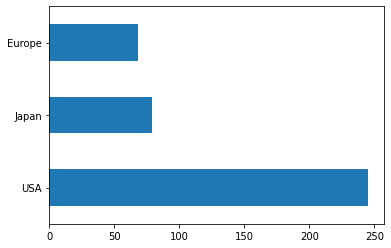

In [22]:
dataset['Origin'].value_counts()[:].plot(kind='barh')

In [23]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


4. Split the data into training and test sets. To reduce the module importing overhead, instead of `sklearn.model_selection.train_test_split()`, use `pd.DataFrame.sample()` to save 80% of the data aside to `train_dataset`, set the random state to be 0 for reproducibility. 

   Then use `pd.DataFrame.drop()` to obtain the `test_dataset`.

In [24]:
train_dataset = dataset.sample(frac=0.8, random_state=0).sort_index(ascending=True)# YOUR CODE HERE
test_dataset = dataset.drop(index=train_dataset.index) # YOUR CODE HERE

In [25]:
train_dataset.head(10)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1
5,15.0,8,429.0,198.0,4341.0,10.0,70,0,0,1
6,14.0,8,454.0,220.0,4354.0,9.0,70,0,0,1
7,14.0,8,440.0,215.0,4312.0,8.5,70,0,0,1
8,14.0,8,455.0,225.0,4425.0,10.0,70,0,0,1
10,15.0,8,383.0,170.0,3563.0,10.0,70,0,0,1


In [26]:
test_dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
9,15.0,8,390.0,190.0,3850.0,8.5,70,0,0,1
25,10.0,8,360.0,215.0,4615.0,14.0,70,0,0,1
28,9.0,8,304.0,193.0,4732.0,18.5,70,0,0,1
31,25.0,4,113.0,95.0,2228.0,14.0,71,0,1,0
33,19.0,6,232.0,100.0,2634.0,13.0,71,0,0,1


In [28]:
print(f"Train set: {train_dataset.shape}, Test set: {test_dataset.shape}")

Train set: (314, 10), Test set: (78, 10)


5. Review the pairwise relationships of a few pairs of columns from the training set. 
   
   The top row suggests that the fuel efficiency (MPG) is a function of all the other parameters. The other rows indicate they are functions of each other.

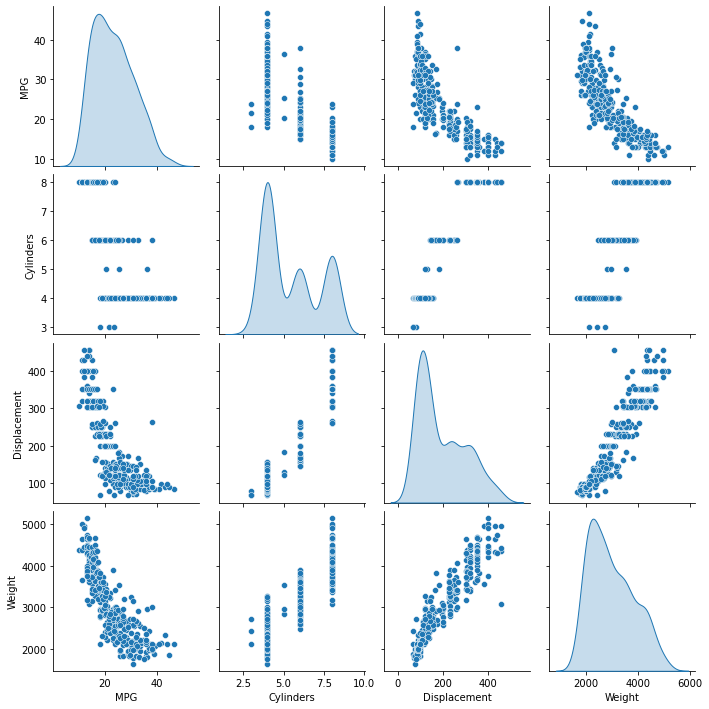

In [27]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde');

Fuel efficiency is shown in the column, `MPG` and it drops with increase in `Cylinders`, `Displacement`, `Weight`. 

Let's also check the overall statistics. Note how each feature covers a very different range:

In [29]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


6. Split features from labels. 
  This means, separate the target value(also called"label") from the features. 
  Label is the value that you will train the model to predict.

In [30]:
train_features = train_dataset.drop(columns=['MPG']) # YOUR CODE HERE
test_features = test_dataset.drop(columns=['MPG']) # YOUR CODE HERE

train_labels = train_dataset['MPG']# YOUR CODE HERE
test_labels = test_dataset['MPG'] # YOUR CODE HERE

In [31]:
train_labels.head()

0    18.0
1    15.0
2    18.0
3    16.0
4    17.0
Name: MPG, dtype: float64

# Task 2 - Normalization Layer

It is good practice to normalize features that use different scales and ranges. Although a model *might* converge without feature normalization, normalization makes training much more stable.

Similar to scikit-learn, tensorflow.keras offers a list of [preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) so that you can build and export models that are truly end-to-end.

1. The Normalization layer ([`tf.keras.layers.Normalization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization)) is a clean and simple way to add feature normalization into your model. The first step is to create the layer:

In [32]:
normalizer = tf.keras.layers.Normalization() # YOUR CODE HERE

2. Then, fit the state of the preprocessing layer to the data by calling [`Normalization.adapt`](https://www.tensorflow.org/guide/keras/preprocessing_layers#the_adapt_method):

In [33]:
normalizer.adapt(train_features)# YOUR CODE HERE

We can see the feature mean and variance are stored in the layer:

In [34]:
print(f'feature mean: {normalizer.mean.numpy().squeeze()}\n')
print(f'feature variance: {normalizer.variance.numpy().squeeze()}')

feature mean: [   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
    0.624]

feature variance: [     2.88   10850.413   1446.699 709896.8        7.755     13.467
      0.147      0.158      0.235]


When the layer is called, it returns the input data, with each feature independently normalized:

In [35]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print('First example:', first)
    print()
    print('Normalized:', normalizer(first).numpy())

First example: [[   8.  307.  130. 3504.   12.   70.    0.    0.    1.]]

Normalized: [[ 1.49  1.07  0.66  0.61 -1.28 -1.61 -0.47 -0.5   0.78]]


# Task 3 - Linear Regression 📈

Before building a deep neural network model, start with linear regression using all the features.

Training a model with `tf.keras` typically starts by defining the model architecture. Use a `tf.keras.Sequential` model, which [represents a sequence of steps](https://www.tensorflow.org/guide/keras/sequential_model).

There are two steps in this multivariate linear regression model:

- Normalize all the input features using the `tf.keras.layers.Normalization` preprocessing layer. You have defined this earlier as `normalizer`.
- Apply a linear transformation ($y = mx+b$ where $m$ is a matrix and $b$ is a vector.) to produce one output using a linear layer ([`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)).

The number of _inputs_ can either be set by the `input_shape` argument, or automatically when the model is run for the first time.

1. Build the Keras Sequential model:

In [46]:
train_features.shape

(314, 9)

In [129]:
linear_model = tf.keras.Sequential([
    normalizer, # YOUR CODE HERE
    tf.keras.layers.Dense(1, activation='linear', input_shape=(9,1)) # YOUR CODE HERE
])

In [130]:
linear_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_5 (Dense)             (None, 1)                 10        
                                                                 
Total params: 29
Trainable params: 10
Non-trainable params: 19
_________________________________________________________________


2. This model will predict `'MPG'` from all features in `train_features`. Run the untrained model on the first 10 data points / rows using `Model.predict()`. The output won't be good, but notice that it has the expected shape of `(10, 1)`:

In [131]:
# YOUR CODE HERE
linear_model.predict(train_features[1:10])

1/1 [==============================] - 0s 53ms/step


array([[0.937],
       [0.474],
       [0.557],
       [0.234],
       [1.68 ],
       [1.923],
       [1.733],
       [2.148],
       [0.862]], dtype=float32)

In [132]:
train_labels[1:10]

1     15.0
2     18.0
3     16.0
4     17.0
5     15.0
6     14.0
7     14.0
8     14.0
10    15.0
Name: MPG, dtype: float64

3. When you call the model, its weight matrices will be built—check that the `kernel` weights (the $m$ in $y = mx + b$) have a shape of (9, 1):

In [133]:
linear_model.layers[1].kernel

<tf.Variable 'dense_5/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.434],
       [ 0.329],
       [ 0.496],
       [ 0.333],
       [ 0.357],
       [-0.014],
       [-0.201],
       [ 0.152],
       [ 0.658]], dtype=float32)>

In [134]:
linear_model.layers[0].weights

[<tf.Variable 'mean:0' shape=(9,) dtype=float32, numpy=
 array([   5.478,  195.318,  104.869, 2990.252,   15.559,   75.898,
           0.178,    0.197,    0.624], dtype=float32)>,
 <tf.Variable 'variance:0' shape=(9,) dtype=float32, numpy=
 array([     2.88 ,  10850.413,   1446.699, 709896.8  ,      7.755,
            13.467,      0.147,      0.158,      0.235], dtype=float32)>,
 <tf.Variable 'count:0' shape=() dtype=int64, numpy=314>]

4. Once the model is built, configure the training procedure using the Keras `Model.compile` method. The most important arguments to compile are the `loss` and the `optimizer`, since these define what will be optimized and how (using the `tf.keras.optimizers.Adam`).

  Here's a list of built-in loss functions in [`tf.keras.losses`](https://www.tensorflow.org/api_docs/python/tf/keras/losses). For regression tasks, [common loss functions](https://towardsdatascience.com/understanding-the-3-most-common-loss-functions-for-machine-learning-regression-23e0ef3e14d3) include mean squared error (MSE) and mean absolute error (MAE). Here,  MAE is preferred such that the model is more robust against outliers. 

  For optimizers, gradient descent (check this video [Gradient Descent, Step-by-Step](https://www.youtube.com/watch?v=sDv4f4s2SB8) for a refresher) is the preferred way to optimize neural networks and many other machine learning algorithms. Read [an overview of graident descent optimizer algorithms](https://ruder.io/optimizing-gradient-descent/) for several popular gradient descent algorithms. Here, we use the popular [`tf.keras.optimizers.Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam), and set the learning rate at 0.1 for faster learning.  

In [135]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.1), # YOUR CODE HERE
    loss='mean_absolute_error' # YOUR CODE HERE
    )

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


5. Use Keras `Model.fit` to execute the training for 100 epochs, set the verbose to 0 to suppress logging and keep 20% of the data for validation:

In [136]:
%%time
history = linear_model.fit(x=train_features, 
                           y=train_labels, 
                           validation_split=0.2,
                           verbose=0, 
                           epochs = 100) # YOUR CODE HERE

2022/12/09 18:59:17 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2239e0971c2a4a9d85b381daf6395556', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2022/12/09 18:59:24 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: tuple index out of range
2022/12/09 18:59:30 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.3.25+cuda11.cudnn805) contains a local version label (+cuda11.cudnn805). MLflow logged a pip requirement for this package as 'jaxlib==0.3.25' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


CPU times: user 5.69 s, sys: 299 ms, total: 5.98 s
Wall time: 12.9 s


6. Visualize the model's training progress using the stats stored in the `history` object:

In [137]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,2.041121,5.009123,95
96,2.051409,4.996429,96
97,2.041214,5.005744,97
98,2.043424,5.129097,98
99,2.035709,5.067991,99


In [138]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

Use `plot_loss(history)` provided to visualize the progression in loss function for training and validation data sets. 

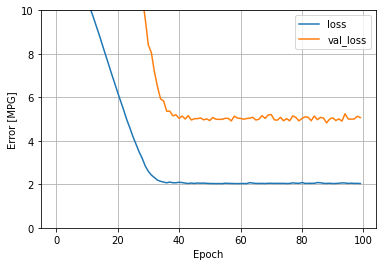

In [139]:
# YOUR CODE HERE
plot_loss(history)

7. Collect the results on the test set for later using [`Model.evaluate()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate)

In [140]:
test_results = {}

test_results['linear_model'] = linear_model.evaluate(x=test_features, y=test_labels) # YOUR CODE HERE

3/3 [==============================] - 0s 5ms/step - loss: 2.7224


In [141]:
test_results

{'linear_model': 2.72239351272583}

# Task 4 - Regression with a Deep Neural Network (DNN)

You just implemented a linear model for multiple inputs. Now, you are ready to implement multiple-input DNN models.

The code is very similar except the model is expanded to include some "hidden" **non-linear** layers. The name "hidden" here just means not directly connected to the inputs or outputs.

* The normalization layer, as before (with `normalizer` for a multiple-input model).
* Two hidden, non-linear, [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layers with the ReLU (`relu`) activation function nonlinearity. One way is to set parameter `activation` inside `Dense` Set the number of neurons at each layer to be 64. 
* A linear `Dense` single-output layer. 



1. Include the model and `compile` method in the `build_and_compile_model` function below. 

In [144]:
def build_and_compile_model(norm):
    model = tf.keras.Sequential([
        # YOUR CODE HERE
        norm,
        tf.keras.layers.Dense(64, activation='relu'), 
        tf.keras.layers.Dense(64, activation='relu'), 
        tf.keras.layers.Dense(1, activation='linear')
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam())
    return model

2. Create a DNN model with `normalizer` (defined earlier) as the normalization layer:



In [151]:
dnn_model = build_and_compile_model(normalizer) # YOUR CODE HERE

3. Inspect the model using `Model.summary()`. This model has quite a few more trainable parameters than the linear models:

In [152]:
dnn_model.summary() # YOUR CODE HERE

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_9 (Dense)             (None, 64)                640       
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


4. Train the model with Keras `Model.fit`:

In [153]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

2022/12/09 19:57:40 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b5444707dbca40efb7681a96a0554346', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2022/12/09 19:57:45 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: Cannot log input example or model signature for input with type <class 'pandas.core.frame.DataFrame'>. TensorFlow Keras autologging can only log input examples and model signatures for the following input types: numpy.ndarray, dict[string -> numpy.ndarray], tensorflow.keras.utils.Sequence, and tensorflow.data.Dataset (TensorFlow >= 2.1.0 required)
2022/12/09 19:57:51 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.3.25+cuda11.cudnn805) contains a local version label (+cuda11.cudnn805). MLflow logged a pip requirement for this package as 'jaxlib==0.3.25' without the local version label

CPU times: user 5.8 s, sys: 327 ms, total: 6.13 s
Wall time: 11.9 s


5. Visualize the model's training progress using the stats stored in the history object. 

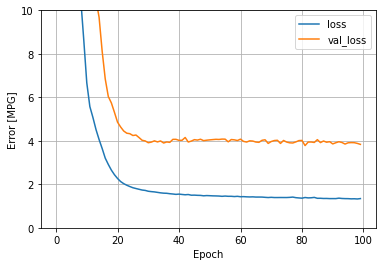

In [154]:
plot_loss(history)

Do you think the DNN model is overfitting? What gives away? 

It appears that the training loss is on a downward trend, but val_loss has stabilised at around 4. This indicates that the model is "memorizing" the training data and is overfitting, but not able to generalise well on the validation data.

6. Let's save the results for later comparison.

In [155]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

# Task 5 - Make Predictions 🔮

1. Since both models have been trained, we can review their test set performance:

In [156]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
linear_model,2.722394
dnn_model,1.933588


These results match the validation error observed during training.

2. We can now make predictions with the `dnn_model` on the test set using Keras `Model.predict` and review the loss. Use `.flatten()`.

3/3 [==============================] - 0s 10ms/step


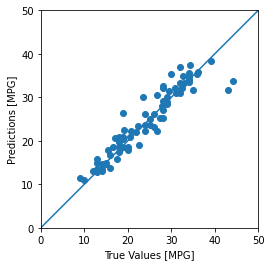

In [157]:
test_predictions = dnn_model.predict(test_features).flatten() # YOUR CODE HERE

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


3. It appears that the model predicts reasonably well. Now, check the error distribution:

Error distribution is normal with a mean around 0. This means the model is well-suited for this data. 

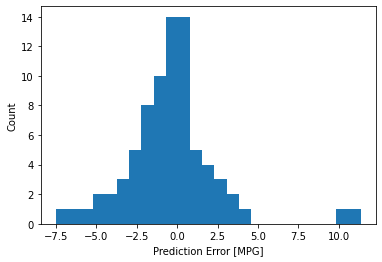

In [162]:
error = test_labels - test_predictions # YOUR CODE HERE
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

4. Save it for later use with `Model.save`:

In [164]:
dnn_model.save('dnn_model')

5. Reload the model with `Model.load_model`; it gives identical output:

In [166]:
reloaded = tf.keras.models.load_model('dnn_model') # YOUR CODE HERE

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [167]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
linear_model,2.722394
dnn_model,1.933588
reloaded,1.933588


# Task 6 - Nonlinearity

We mentioned that the `relu` activation function introduce non-linearity; let's visualize it. Since there are six numerical features and 1 categorical features, it is impossible to plot all the dimensions on a 2D plot; we need to simplify/isolate it. 

Note: in this task, code is provided; the focus in on understanding. 

1. We focus on the relationship between feature `Displacement` and target `MPG`. 
  
  To do so, create a new dataset of the same size as `train_features`, but all other features are set at their median values; then set the `Displacement` between 0 and 500. 

In [168]:
fake = np.outer(np.ones(train_features.shape[0]), train_features.median())
fake = pd.DataFrame(fake, columns = train_features.columns)
fake.Displacement = np.linspace(0, 500, train_features.shape[0])

2. Create a plotting function to:

    a) visualize real values between `Displacement` and `MPG` from the training dataset in scatter plot 
    
    b) overlay the predicted MPG from Displacement varying from 0 to 500, but holding all other features constant. 

In [169]:
def plot_displacement(x, y):
    plt.scatter(train_features['Displacement'], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Displacement')
    plt.ylabel('MPG')
    plt.legend()

3. Visualize predicted MPG using the linear model.

In [207]:
pd.DataFrame(linear_model.layers[1].weights[0].numpy(), index = train_features.columns)

,0
Cylinders,-0.785287
Displacement,-0.052336
Horsepower,-1.161682
Weight,-3.058420
Acceleration,-1.129718
Model Year,1.652623
Europe,0.589342
Japan,0.845510
USA,0.121855


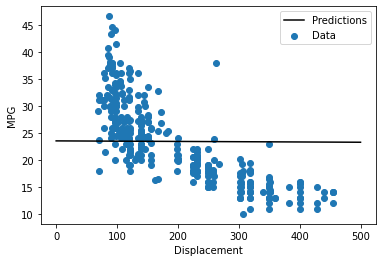

In [170]:
plot_displacement(fake.Displacement, linear_model(fake))

In [209]:
train_dataset.Displacement.describe()

count    314.000000
mean     195.318471
std      104.331589
min       68.000000
25%      105.500000
50%      151.000000
75%      265.750000
max      455.000000
Name: Displacement, dtype: float64

In [210]:
fake.Displacement.describe()

count    314.000000
mean     250.000000
std      145.029098
min        0.000000
25%      125.000000
50%      250.000000
75%      375.000000
max      500.000000
Name: Displacement, dtype: float64

In [214]:
pd.DataFrame(normalizer(fake)[1].numpy()).describe()

,0
count,9.000000
mean,-0.375745
std,0.718200
min,-1.859746
25%,-0.496016
50%,-0.272625
75%,-0.021271
max,0.775913


In [217]:
print(f"min: {-0.052*-1.859746}, max: {-0.052*0.775813}")

min: 0.09670679199999999, max: -0.040342275999999996


Although the MAE of the linear_model was very close to the dnn_model (2.7 vs 1.9), it appears that the relationship between Displacement and MPG is not captured at all by the linear model - its a horizontal line! But in the pair plot there is a clear negative non-linear relationship. Why is this the case? 
* Checking the range of values of Displacement, [68, 455], the range in the fake data is indeed appropriate. 
* Notice the coefficient of Displacement in the linear model above, it is -0.052. Keeping all other features constant, the variation in MPG due to Displacement is only from 0.09 to -0.04. That is why we see an almost horizontal line. 
* This could be because Displacement is highly correlated with Weight, and Weight has a higher coefficient value at -3.06. Maybe Weight will a better illustration than displacement. 

4. Visualize predicted MPG using the neural network model. Do you see an improvement/non-linearity from the linear model? 

Yes! With the `dnn_model`, the predictions are non-linear and captures the . It could be a better fit, bit this is definitely better than the straight line from the `linear_model`.

10/10 [==============================] - 0s 2ms/step


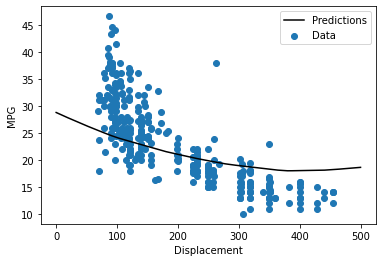

In [171]:
plot_displacement(fake.Displacement, dnn_model.predict(fake))

5. What are the other activation functions? Check the list of [activations](https://www.tensorflow.org/api_docs/python/tf/keras/activations). 
  
  Optional. Modify the DNN model with a different activation function, and fit it on the data; does it perform better? 

In [220]:
dnn_model_opt = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(64, activation='tanh'), 
    tf.keras.layers.Dense(64, activation='tanh'), 
    tf.keras.layers.Dense(1, activation='linear')  
])

In [221]:
dnn_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_9 (Dense)             (None, 64)                640       
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [222]:
dnn_model_opt.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
                      loss = 'mean_absolute_error')

In [223]:
%%time
history = dnn_model_opt.fit(train_features, 
                  train_labels, 
                  validation_split=0.2,
                  verbose=0,
                  epochs=100)

2022/12/09 20:47:58 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '54a5b92abbfe4f3d9452b2f28145d7d9', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2022/12/09 20:48:04 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: Cannot log input example or model signature for input with type <class 'pandas.core.frame.DataFrame'>. TensorFlow Keras autologging can only log input examples and model signatures for the following input types: numpy.ndarray, dict[string -> numpy.ndarray], tensorflow.keras.utils.Sequence, and tensorflow.data.Dataset (TensorFlow >= 2.1.0 required)
2022/12/09 20:48:12 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.3.25+cuda11.cudnn805) contains a local version label (+cuda11.cudnn805). MLflow logged a pip requirement for this package as 'jaxlib==0.3.25' without the local version label

CPU times: user 6.38 s, sys: 291 ms, total: 6.67 s
Wall time: 14.1 s


In [224]:
test_results['dnn_model_opt'] = dnn_model_opt.evaluate(
    test_features, test_labels, verbose=0)

In [225]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
linear_model,2.722394
dnn_model,1.933588
reloaded,1.933588
dnn_model_opt,2.224593


Using `tanh` activation made the results slightly worse compared to using `relu`. 

6. Overfitting is a common problem for DNN models, how should we deal with it? Check [Regularizers](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers) on tf.keras. Any other techniques that are invented for neural networks? 

[Dropout layers](https://keras.io/api/layers/regularization_layers/)  can be added for regularisation. 

# Task 7 - MLflow Tracking

In this task, we briefly explore [MLflow Tracking](https://www.mlflow.org/docs/latest/tracking.html#tracking), one of four primary functions that MLflow offers for managing the end-to-end machine learning lifecycle. We will access the information runs programmatically in python and then set up the MLflow UI for easy interaction.

1. Experiments.

    MLflow Tracking is organized around the concept of `runs`, which are executions of some piece of modeling code; and runs are organized into experiments. 

    We set the auto logging in the beginning, we can verify that
    - there is one experiment
    - its name is `0`
    - all of its artifacts are stored at `file:///content/mlruns/0` in Google Drive.

In [228]:
from mlflow import MlflowClient
client = MlflowClient()
client.search_experiments() 

[<Experiment: artifact_location='file:///content/mlruns/0', creation_time=1670610927001, experiment_id='0', last_update_time=1670610927001, lifecycle_stage='active', name='Default', tags={}>]

2. Runs. 

   List information for runs that are under experiment '0' using [`mlflow.list_run_infos()`](https://www.mlflow.org/docs/latest/python_api/mlflow.html#mlflow.list_run_infos).

In [241]:
# YOUR CODE HERE
experiment_id = '0'
df = mlflow.search_runs([experiment_id], order_by=["metrics.m DESC"])
df.head(2)

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.val_loss,metrics.loss,params.opt_decay,params.steps_per_epoch,...,params.epochs,params.opt_name,params.opt_epsilon,params.validation_split,tags.mlflow.source.name,tags.mlflow.runName,tags.mlflow.autologging,tags.mlflow.log-model.history,tags.mlflow.source.type,tags.mlflow.user
0,54a5b92abbfe4f3d9452b2f28145d7d9,0,FINISHED,file:///content/mlruns/0/54a5b92abbfe4f3d9452b...,2022-12-09 20:47:58.097000+00:00,2022-12-09 20:48:12.155000+00:00,3.520465,1.970487,0.0,None,...,100,Adam,1e-07,0.2,/usr/local/lib/python3.8/dist-packages/ipykern...,loud-mink-65,tensorflow,"[{""run_id"": ""54a5b92abbfe4f3d9452b2f28145d7d9""...",LOCAL,root
1,b5444707dbca40efb7681a96a0554346,0,FINISHED,file:///content/mlruns/0/b5444707dbca40efb7681...,2022-12-09 19:57:40.100000+00:00,2022-12-09 19:57:51.949000+00:00,3.837479,1.343515,0.0,None,...,100,Adam,1e-07,0.2,/usr/local/lib/python3.8/dist-packages/ipykern...,adaptable-stag-210,tensorflow,"[{""run_id"": ""b5444707dbca40efb7681a96a0554346""...",LOCAL,root


3. Retrieve the currently active run, i.e., the DNN model. Hint: `mlflow.last_active_run()` 

In [234]:
autolog_run = mlflow.last_active_run() # YOUR CODE HERE

4. Use function `print_auto_logged_info` provided below to fetch the auto logged parameters and metrics for `autolog_run`. 

In [242]:
import json
def print_auto_logged_info(r):
    tags = {k: v for k, v in r.data.tags.items() if not k.startswith("mlflow.")}
    artifacts = [f.path for f in MlflowClient().list_artifacts(r.info.run_id, "model")]
    print("run_id: {}".format(r.info.run_id))
    print("artifacts: {}".format(artifacts))
    print("params: {}".format(json.dumps(r.data.params, indent=4)))
    print("metrics: {}".format(r.data.metrics))
    print("tags: {}".format(tags))

In [243]:
print_auto_logged_info(
    # YOUR CODE HERE
    autolog_run
    ) 

run_id: 54a5b92abbfe4f3d9452b2f28145d7d9
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/data', 'model/python_env.yaml', 'model/requirements.txt']
params: {
    "epochs": "100",
    "workers": "1",
    "opt_amsgrad": "False",
    "validation_freq": "1",
    "class_weight": "None",
    "opt_epsilon": "1e-07",
    "opt_beta_2": "0.999",
    "steps_per_epoch": "None",
    "initial_epoch": "0",
    "opt_name": "Adam",
    "shuffle": "True",
    "batch_size": "None",
    "max_queue_size": "10",
    "validation_split": "0.2",
    "use_multiprocessing": "False",
    "opt_beta_1": "0.9",
    "validation_batch_size": "None",
    "opt_decay": "0.0",
    "sample_weight": "None",
    "validation_steps": "None",
    "opt_learning_rate": "0.1"
}
metrics: {'loss': 1.970487356185913, 'val_loss': 3.5204648971557617}
tags: {}


5. Optional. Retrieve the best run using [MlflowClient().search_runs()](https://www.mlflow.org/docs/latest/search-runs.html#python).

In [249]:
runs = client.search_runs(experiment_id, order_by=["metrics.loss ASC"]) # YOUR CODE HERE

In [250]:
runs[0]

<Run: data=<RunData: metrics={'loss': 1.1231389045715332, 'val_loss': 4.4488115310668945}, params={'batch_size': 'None',
 'class_weight': 'None',
 'epochs': '100',
 'initial_epoch': '0',
 'max_queue_size': '10',
 'opt_amsgrad': 'False',
 'opt_beta_1': '0.9',
 'opt_beta_2': '0.999',
 'opt_decay': '0.0',
 'opt_epsilon': '1e-07',
 'opt_learning_rate': '0.1',
 'opt_name': 'Adam',
 'sample_weight': 'None',
 'shuffle': 'True',
 'steps_per_epoch': 'None',
 'use_multiprocessing': 'False',
 'validation_batch_size': 'None',
 'validation_freq': '1',
 'validation_split': '0.8',
 'validation_steps': 'None',
 'workers': '1'}, tags={'mlflow.autologging': 'tensorflow',
 'mlflow.log-model.history': '[{"run_id": "2382aba316e34ab5813322da23281f4f", '
                             '"artifact_path": "model", "utc_time_created": '
                             '"2022-12-09 18:42:49.783453", "flavors": '
                             '{"tensorflow": {"code": null, "data": "data", '
                             

6. To see what's logged in the file system `/content/mlruns/`, click tab `files` in the left sidepanel in Colab. For example, 
    ```
    mlruns
    └── 0
        ├── 3a5aebdd35ef46fb8dc35b40e542f0a4
        │   ├── artifacts
        │   ├── meta.yaml
        │   ├── metrics
        │   ├── params
        │   └── tags
        ├── c627bc526c4a4c418a8285627e61a16d
        │   ├── artifacts
        │   ├── meta.yaml
        │   ├── metrics
        │   ├── params
        │   └── tags
        └── meta.yaml

    11 directories, 3 files
    ```

    Inspect the model summary of the DNN model you ran previously; it is located at `artifacts/model_summary.txt` of the corresponding run. Use `cat $filepath`. 

In [255]:
# YOUR CODE HERE (bash)
!cat ./mlruns/0/e4d3f847766c40e29b39665732099173/artifacts/model_summary.txt

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_6 (Dense)             (None, 64)                640       
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________

7. Tracking UI. 

    MLflow provides an UI for us to visualize, search and compare runs, as well as download run artifacts or metadata for analysis in other tools. 

    If your runs are logged to a local mlruns directory, run `mlflow ui` in the directory above it will load the corresponding runs. 
    
    Running localhost server in Colab, however, requires a bit of extra work:
    - set up a free account on [ngrok](https://dashboard.ngrok.com/get-started/setup)
    - retrieve the authtoken from https://dashboard.ngrok.com/auth and update the code cell below
    
   **NOTE**. NEVER share your secrets. Best to keep `NGROK_AUTH_TOKEN` as an environment variable and retrieve it via `os.environ.get("NGROK_AUTH_TOKEN")`.

In [256]:
# run tracking UI in the background
get_ipython().system_raw("mlflow ui --port 5000 &") 

# create remote tunnel using ngrok.com to allow local port access
from pyngrok import ngrok
# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (see Note above)
NGROK_AUTH_TOKEN = "xxxx"  # YOUR CODE HERE
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://b548-34-75-191-247.ngrok.io


8. Interact with Tracking UI. 

    Open the link, output from the previous cell. get oriented, `Parameters`, `Metrics`, `Artifacts`, and so on.
    
    When you are done, make sure to terminate the open tunnel:

In [258]:
ngrok.kill()

# Task 8 - AutoML with TPOT 🫖

1. Instantiate and train a TPOT auto-ML regressor.

  The parameters are set fairly arbitrarily (if time permits, you shall experiment with different sets of parameters after reading [what each parameter does](http://epistasislab.github.io/tpot/api/#regression)). Use these parameter values:

  `generations`: 10

  `population_size`: 40

  `scoring`: negative mean absolute error; read more in [scoring functions in TPOT](http://epistasislab.github.io/tpot/using/#scoring-functions)

  `verbosity`: 2 (so you can see each generation's performance)

  The final line with create a Python script tpot_products_pipeline.py with the code to create the optimal model found by TPOT.

In [259]:
%%time
from tpot import TPOTRegressor
tpot = TPOTRegressor(generations=10, 
                     population_size=40,
                     scoring='neg_mean_absolute_error', # YOUR CODE HERE
                     verbosity=2,
                     random_state=42)
tpot.fit(train_features, train_labels)
print(f"Tpop score on test data: {tpot.score(test_features, test_labels):.2f}")
tpot.export('tpot_mpg_pipeline.py')

Optimization Progress:   0%|          | 0/440 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -2.43140703927203

Generation 2 - Current best internal CV score: -2.430098252839522

Generation 3 - Current best internal CV score: -2.38976685357061

Generation 4 - Current best internal CV score: -2.346953846731865

Generation 5 - Current best internal CV score: -2.346953846731865

Generation 6 - Current best internal CV score: -2.346953846731865

Generation 7 - Current best internal CV score: -2.2640815726468135

Generation 8 - Current best internal CV score: -2.2640815726468135

Generation 9 - Current best internal CV score: -2.2640815726468135

Generation 10 - Current best internal CV score: -2.2640815726468135

Best pipeline: RandomForestRegressor(ZeroCount(AdaBoostRegressor(input_matrix, learning_rate=1.0, loss=square, n_estimators=100)), bootstrap=False, max_features=0.5, min_samples_leaf=2, min_samples_split=18, n_estimators=100)
Tpop score on test data: -1.80
CPU times: user 7min 53s, sys: 17.2 s, total: 8min 11s
Wall time: 8mi

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(


2. Examine the model pipeline that TPOT regressor offers. If you see any model, function, or class that are not familiar, look them up! 

  Note: There is randomness to the way the TPOT searches, so it's possible you won't have exactly the same result as your classmate. 

In [260]:
cat tpot_mpg_pipeline.py

import numpy as np
import pandas as pd
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator, ZeroCount
from tpot.export_utils import set_param_recursive

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'], random_state=42)

# Average CV score on the training set was: -2.2640815726468135
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=AdaBoostRegressor(learning_rate=1.0, loss="square", n_estimators=100)),
    ZeroCount(),
    RandomForestRegressor(bootstrap=False, max_features=0.5, min_samples_leaf=2, min_samples_spl

3. Take the appropriate lines (e.g., updating path to data and the variable names) from `tpot_mpg_pipeline.py` to build a model on our training set and make predictions on the test set. 
Save the predictions as `y_pred`, and compute appropriate evaluation metric. 
You may find that for this simple data set, the neural network we built outperforms the tree-based model, yet note it is not a conclusion that we can generalize for all tabular data. 

In [261]:
!cp tpot_mpg_pipeline.py /content/drive/MyDrive/GitHub/

In [295]:
import numpy as np
import pandas as pd
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator, ZeroCount
from tpot.export_utils import set_param_recursive

In [296]:
# Average CV score on the training set was: -2.2640815726468135
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=AdaBoostRegressor(learning_rate=1.0, loss="square", n_estimators=100)),
    ZeroCount(),
    RandomForestRegressor(bootstrap=False, max_features=0.5, min_samples_leaf=2, min_samples_split=18, n_estimators=100)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 42)

exported_pipeline.fit(train_features, train_labels)
ypred = exported_pipeline.predict(test_features)

X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
X does not have valid feature names, but AdaBoostRegressor was fitted with feature names


In [298]:
ypred = tpot.predict(test_features)

X does not have valid feature names, but AdaBoostRegressor was fitted with feature names


In [302]:
(abs(ypred - test_labels)).mean()

1.8008425462263982

In [303]:
abs(tpot.predict(train_features) - train_labels).mean()

X does not have valid feature names, but AdaBoostRegressor was fitted with feature names


1.1772715830571538

# Task 9 - Model Explainability

Last week, we introduced model explainability with SHAP and will continue to incorporate it as part our model output this week.  You can use the [Kernel Explainer](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/neural_networks/Census%20income%20classification%20with%20Keras.html) for explainability of both the Neural Networks and the TPOT classifier.  

In [284]:
import shap
import warnings

# YOUR CODE GOES HERE!
explainer = shap.KernelExplainer(dnn_model, train_features)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    shap_values = explainer.shap_values(train_features.iloc[0:100, :], nsamples=100)

  0%|          | 0/100 [00:00<?, ?it/s]

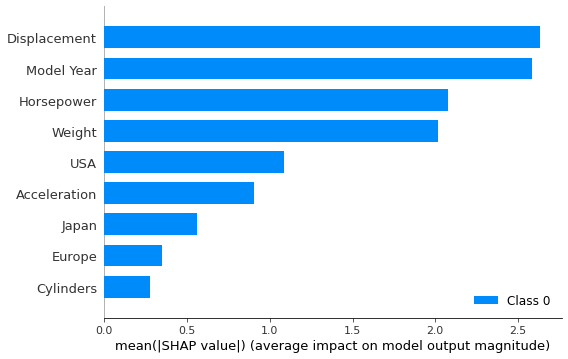

In [285]:
shap.summary_plot(shap_values, train_features.iloc[0:100,:])

In [288]:
tpot.fitted_pipeline_

Pipeline(steps=[('stackingestimator',
                 StackingEstimator(estimator=AdaBoostRegressor(loss='square',
                                                               n_estimators=100,
                                                               random_state=42))),
                ('zerocount', ZeroCount()),
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=False, max_features=0.5,
                                       min_samples_leaf=2, min_samples_split=18,
                                       random_state=42))])

# Task 10 - Taking it to the Next Level! 📶

Let's take our models and make a model comparison demo like we did last week, but this time you're taking the lead!  
    
1. Save your training dataset as a CSV file so that it can be used in the Streamlit app.
1. Build a results DataFrame and save it as a CSV so that it can be used in the Streamlit app.
1. In Tab 1 - Raw Data:
* Display your training dataset in a Streamlit DataFrame (`st.DataFrame`).
* Build 1-2 interactive Plotly visualizations that explore the dataset (correlations, scatterplot, etc.)
2. In Tab 2 - Model Results:
* Display your performance metrics appropriately using 2-3 metrics for model comparison.
3. In Tab 3 - Model Explainability:
* Make local and global explainability plots to compare two models at a time side-by-side.  [Here](https://www.kaggle.com/code/elsa155026/uciheart-kernel-shap-and-interactive-visualization/notebook) is a good example if how to create some different explainability plots using Plotly.

# Additional Resources

- [Tensorflow playground](https://playground.tensorflow.org/) for an interactive experience to understand how nueral networkds work.

- [An Introduction to Deep Learning for Tabular Data](https://www.fast.ai/2018/04/29/categorical-embeddings/) covers embeddings for categorical variables. 

- [Imbalanced classification: credit card fraud detection](https://keras.io/examples/structured_data/imbalanced_classification/) demonstrates using `class_weight` to handle imbalanced classification problems. 

# Acknowledgement and Copyright

##### Acknowledgement

This notebook is adapted from [tensorflow/keras tuorial - regression](https://www.tensorflow.org/tutorials/keras/regression)

##### Copyright 2018 The TensorFlow Authors.

@title Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

@title MIT License

Copyright (c) 2017 François Chollet

Permission is hereby granted, free of charge, to any person obtaining a
copy of this software and associated documentation files (the "Software"),
to deal in the Software without restriction, including without limitation
the rights to use, copy, modify, merge, publish, distribute, sublicense,
and/or sell copies of the Software, and to permit persons to whom the
Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in
all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
DEALINGS IN THE SOFTWARE.

## Answers to Rubrics Questions

### What is Normalization and how does Normalization make training a model more stable?

Normalization is performed on numeric data to transform these features to have a common scale. Some common ways to do this: 
1. Min-max scaling: This scales the data to [0,1] scale, such that 0 is at min, and 1 is at max. 
2. z-score: This scales the data such that its mean is 0, and standard deviation is 1.

Normalisation helps the gradient descent algorithm converge faster, as the mean square error curve (multi-dimensional) is more symmetric and the algorithm can move towards the minimum from all directions without oscillating. 

Also in models such as linear/logistic regression, normalisation allows us to compare the coefficients of the features in the model directly to determine feature importance. 

### What are loss and optimizer functions and how do they work? What is Gradient Descent and how does it work?

The loss function is used to evaluate the prediction of a model compared to the ground truth target variable. It is the penalty for a bad prediction. 
* In regression problems, where the model predicts a continuous value, loss functions such as mean absolute error or mean squared error is used. 
* In classification problems, where the model predicts a class with a probability, the log loss function is used. 

The loss function accumulates the loss values for all the data points in the training data. For each combination of parameters of the model, a loss value can be calculated. This gives a loss curve over the parameter space. The loss function is chosen such that the loss curve is bowl-shaped (convex) and has a minimum value. This minimum value represents the best possible model that we can hope to achieve. 

Optimizer function implements the optimisation algorithm that iteratively updates the model parameters to minimize the loss, until it converges to this best model or the minimum point in the loss curve. 

The model is initialised with a set of parameters and the loss is computed on the predictions of the training data. Using the loss, the parameters are updated (intelligently), and the next round of predictions is performed and loss is calculated, and if the algorithm worked well, loss is reduced. This process is repeated until the loss does not change or changes only slightly. 

Gradient descent is an example of such an optimisation function. To update the parameters so that the algorithm moves "down" the loss curve, in gradient descent, the gradient of the loss curve is computed and a fraction of the gradient value is added to the parameters. This is repeated as the model edges closer to the minimum point in the loss curve.

### What is an activation function? What are the outputs of the following activation functions: ReLU, Softmax, Tanh, Sigmoid

Activation function is a function that is used in neural networks to learn the non-linear relationship between the features and the target variable. By definition, activation functions are never straight lines (linear). It is applied at a neuron to the linear combination of weights and inputs from previous layer. 
1. ReLU: It stands for Rectified Linear Unit. For inputs less than 0, it is 0 and for positive inputs, the input is passed on as is. 
2. Tanh: This activation function squishifies the input. The activation goes from -1 to 1, crossing y-axis at 0, i.e. when input is 0, activation is 0. For large values of input, activation is 1, and for small values, it is -1. And for values of inputs close to 0, the output is linear. 
3. Sigmoid: Similar to tanh, but goes from 0 to 1. 
4. Softmax: This is a special type of activation, that is implemented as a layer of output neurons for multi-class classification problems. The number of neurons in softmax layer is equal to the number of classes being predicted. Softmax assigns decimal probabilities to each class such that the probabilities add up to 1. Note that softmax assumes that each data input belongs to only one class.  

### What is the TPOT algorithm and how does it work? What does TPOT stand for?

TPOT stands for Tree-based Pipeline Optimisation Tool. TPOT is an automated machine learning (AutoML) tool, that automates the laborious process of designing ML pipeline. 
* It represents the possible ML pipelines in a tree and uses genetic programming to optimise accuracy while keeping track of model complexity. 
* It generates an optimised ML pipeline for feature engineering (preprocessing, selection), model selection and parameter optimisation. 